# Preparing data for forecasting

In [127]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np

## Reading data

In [128]:
df = pd.read_csv('../data/input/df_ts_epidemic_episodes.csv', index_col=0)
df.DATA = pd.to_datetime(df.DATA, infer_datetime_format=True)

In [129]:
list_municipalities = df['MUNICIPIO'].unique()

In [130]:
epidemiologic_weeks = [pd.to_datetime('2020-04-26'), pd.to_datetime('2020-07-19'), pd.to_datetime('2020-10-11'), pd.to_datetime('2021-01-03'), pd.to_datetime('2021-03-28'), pd.to_datetime('2021-06-20')]

In [131]:
FORECASTING_HORIZON = 84
NUMBER_OF_SAMPLES = 20

## Original dataset

In [132]:
df = df.sort_values(by=['MUNICIPIO','DATA'])

In [133]:
df.columns

Index(['DATA', 'CODIGO_MUNICIPIO_6', 'NOVOS_CASOS_SRAG', 'OBITOS_NOVOS',
       'OBITOS', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS_NOVOS',
       'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS', 'casosNovos',
       'casosAcumulado', 'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'MUNICIPIO',
       'SIGLA_ESTADO', 'ESTADO', 'REGIAO', 'POPULACAO_2022',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL

In [134]:
max_date = epidemiologic_weeks[-1] + pd.Timedelta(days=FORECASTING_HORIZON-1)

In [135]:
df_original = df.loc[df['DATA']<=max_date]

## Noised dataset

In [136]:
df_noised = pd.DataFrame()
for municipality in list_municipalities:
    df_municipality = df_original.loc[df['MUNICIPIO']==municipality]
    
    for i in range(NUMBER_OF_SAMPLES):
        ts_data = df_municipality.set_index('DATA')['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] 
        noise = np.random.uniform(low=-0.01, high=0.01, size=len(ts_data))
        noise_scaled = noise * ts_data
        ts_data_noised = ts_data + noise_scaled
        ts_data_noised[ts_data_noised < 0] = 0
        
        df_municipality_noised = df_municipality.copy()
        df_municipality_noised['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED'] = ts_data_noised.values
        df_municipality_noised['AMOSTRA'] = i  
        
        df_noised = pd.concat([df_noised, df_municipality_noised])

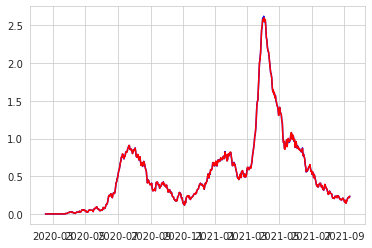

In [137]:
import matplotlib.pyplot as plt

plt.plot(df_original[df_original['MUNICIPIO']=='Belo Horizonte']['DATA'], df_original[df_original['MUNICIPIO']=='Belo Horizonte']['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'], color='blue')
plt.plot(df_noised[(df_noised['MUNICIPIO']=='Belo Horizonte') & (df_noised['AMOSTRA']==1)]['DATA'], df_noised[(df_noised['MUNICIPIO']=='Belo Horizonte') & (df_noised['AMOSTRA']==1)]['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED'], color='red')
plt.show()

In [138]:
diff = df_original[df_original['MUNICIPIO']=='Belo Horizonte']['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] - df_noised[(df_noised['MUNICIPIO']=='Belo Horizonte') & (df_noised['AMOSTRA']==1)]['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED']

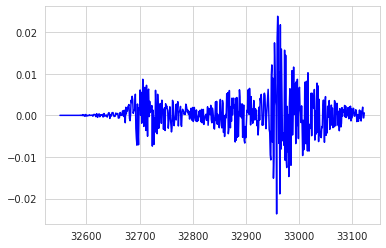

In [139]:
import matplotlib.pyplot as plt

plt.plot(diff, color='blue')
plt.show()

In [140]:
df_noised[['MUNICIPIO','AMOSTRA']].drop_duplicates()

,MUNICIPIO,AMOSTRA
0,Manaus,0
0,Manaus,1
0,Manaus,2
0,Manaus,3
0,Manaus,4
...,...,...
42000,Londrina,15
42000,Londrina,16
42000,Londrina,17
42000,Londrina,18


## Stationary dataset

In [141]:
# Function to check stationarity
def check_stationarity(ts_data):
    # Perform Dickey-Fuller test
    result = adfuller(ts_data)
    p_value = result[1]
    
    # Return True if p-value is less than or equal to 0.05 (indicating stationarity), otherwise False
    return p_value <= 0.05

In [151]:
df_noised_stationary = pd.DataFrame()

for municipality in df_noised['MUNICIPIO'].unique():        
    df_municipality = df_noised.loc[(df_noised.MUNICIPIO == municipality)]
    municipality_id = df_municipality.CODIGO_MUNICIPIO_6.unique()[0]
    
    for sample in df_municipality['AMOSTRA'].unique():
        df_municipality_sample = df_municipality.loc[df_municipality['AMOSTRA']==sample]
        df_municipality_sample = df_municipality_sample.set_index('DATA')

        ts_data = df_municipality_sample['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED']
        ts_data_diff = ts_data                  
        
        differentiation_order = 0        
        while(check_stationarity(ts_data_diff)==False):
            ts_data_diff = ts_data.diff().dropna()
            differentiation_order += 1
            
        df_municipality_sample['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED_STATIONARY'] = None
        df_municipality_sample.loc[ts_data_diff.index, 'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED_STATIONARY'] = ts_data_diff.values
        df_municipality_sample['DIFFERENTIATION_ORDER'] = differentiation_order
        df_municipality_sample = df_municipality_sample.reset_index()
        
        df_noised_stationary = pd.concat([df_noised_stationary, df_municipality_sample], ignore_index=True)

In [153]:
df_noised_stationary[['MUNICIPIO','AMOSTRA','DIFFERENTIATION_ORDER']].drop_duplicates()

,MUNICIPIO,AMOSTRA,DIFFERENTIATION_ORDER
0,Manaus,0,0
574,Manaus,1,0
1148,Manaus,2,0
1722,Manaus,3,0
2296,Manaus,4,0
...,...,...,...
467810,Londrina,15,1
468384,Londrina,16,1
468958,Londrina,17,1
469532,Londrina,18,1


In [155]:
df_noised_stationary.groupby(['DIFFERENTIATION_ORDER'])['DATA'].count()

DIFFERENTIATION_ORDER
0    268632
1    202048
Name: DATA, dtype: int64

In [156]:
count_non_stationarity = 0
count_stationarity = 0

for municipality in df_original['MUNICIPIO'].unique():
    df_municipality = df_original.loc[df['MUNICIPIO']==municipality]
    ts_data = df_municipality_sample['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_NOISED']
    if(check_stationarity(ts_data)==False):
      count_non_stationarity += 1
    else:
        count_stationarity += 1

In [157]:
count_non_stationarity

41

In [158]:
count_stationarity

0

Note: without noise all time series are non-stationary. But, when I introduce noise in time series, I get 57% of the time series with stationarity. We only need apply diferentiation for 43% of my noised time series. 

## Saving data

In [159]:
df_original.to_csv('data/df_original.csv', index=False)
df_noised.to_csv('data/df_noised.csv', index=False)
df_noised_stationary.to_csv('data/df_noised_stationary.csv', index=False)